In [16]:
import torch
import torch.functional as F
import torch.nn as nn

In [17]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Found cached dataset emotion (/Users/nicholasdinicola/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)
100%|██████████| 3/3 [00:00<00:00, 1241.65it/s]


In [18]:
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [19]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [20]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


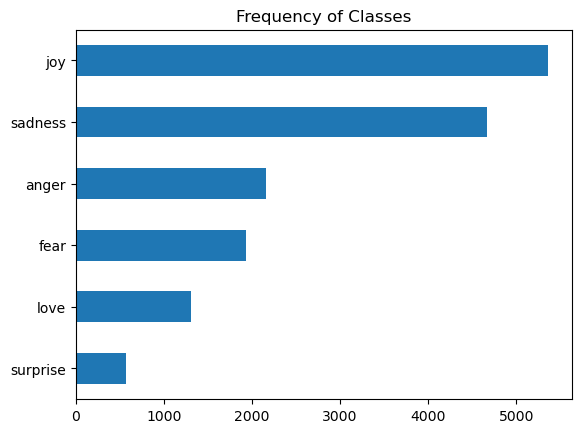

In [21]:
import matplotlib.pyplot as plt

df.label_name.value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

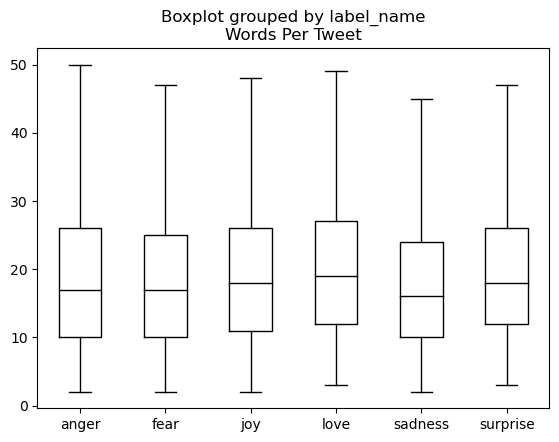

In [22]:
# DistilBERT has a max context size of 512; here the max input gets to len = 50
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")

plt.xlabel("")
plt.show()

In [23]:
emotions.reset_format()

### Subword Tokenization

WordPiece algorithm is used by BERT and DistilBERT

In [24]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [25]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)


In [26]:
text = "I love studying math and NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 5702, 8785, 1998, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [27]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'love', 'studying', 'math', 'and', 'nl', '##p', '.', '[SEP]']


In [28]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] i love studying math and nlp. [SEP]


In [29]:
tokenizer.vocab_size, tokenizer.model_max_length # model context size

(30522, 512)

### Tokenizing the whole dataset

In [30]:
# We can see the result of padding in the first element which has been fulled of zeros to match the second input len
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [31]:
# Apply the tokenize function to the whole dataset

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask']


### Use Pretrained Model - Feature Extraction

In [32]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading: 100%|██████████| 256M/256M [00:43<00:00, 6.23MB/s] 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Example of extracting the last hidden states from a single string

In [33]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [34]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [35]:
outputs.last_hidden_state.size() # (batch_size x n_tokens x hiden_dim)

torch.Size([1, 6, 768])

In [36]:
# First token -> CLS -> hidden state; It si common practice to use this state for classification tasks
# cause it appears at the beginning of every inputs
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

### Extract the last hidden state for the whole dataset

In [37]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        # Return vector for [CLS] token
        return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True) # default batch_size = 1_000

 50%|█████     | 1/2 [00:15<00:15, 15.60s/ba]


In [38]:
# hidden_state columns added
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a feature matrix

In [39]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualize the Dataste

In [41]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.480797,7.049049,0
1,-2.682696,6.220370,0
2,5.596402,3.514869,3
3,-2.339111,3.624833,2
4,-3.035923,4.299275,3


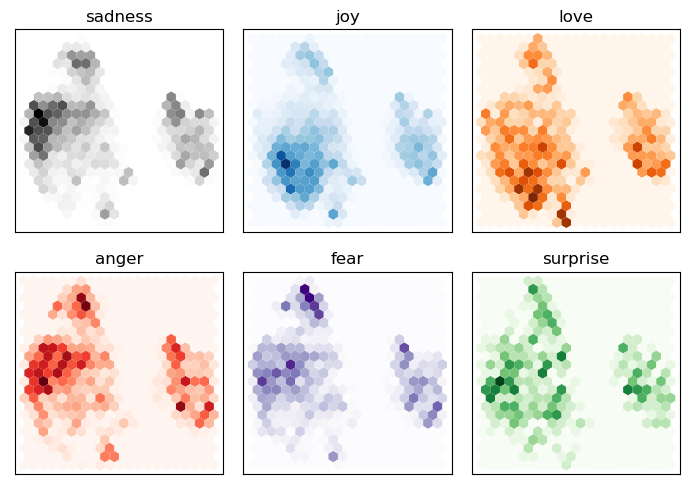

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Training a simple classifier

In [44]:
# baseline 
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [43]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3_000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

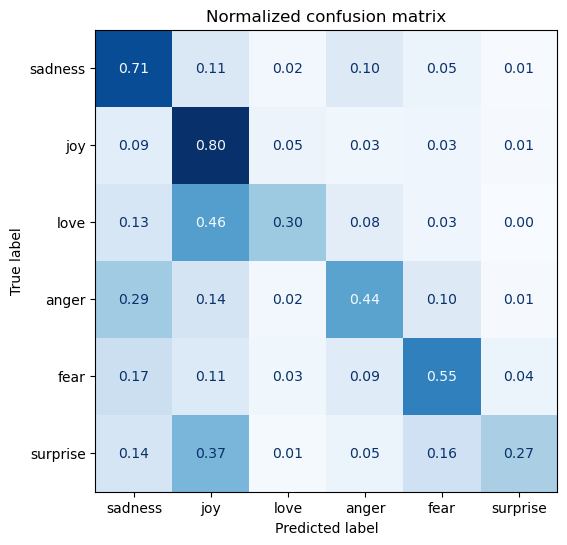

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels): 
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()

y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)


### Fine tuning a classification model 

In [49]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [50]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred): 
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}